# Module

In [1]:
# !chmod 600 ~/.kaggle/kaggle.json

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
np.random.seed(2024)
random.seed(2024)

# Func

In [4]:
def load_data():    
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')    
    all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
    return train, test, all_df

In [5]:
def skewed(df, all_df):
    pt = PowerTransformer(method='yeo-johnson') # yeo-johnson : 음수값 포함, box-cox : 양수값만
    pt.fit(df[['Annual Income']])
    all_df['transformed_Annual_Income'] = pt.transform(all_df[['Annual Income']])
    all_df['log_Premium_Amount'] = np.log1p(all_df['Premium Amount'])
    return pt, all_df

In [6]:
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

In [7]:
def prep():
    train, test, all_df = load_data()
    pt, all_df = skewed(train, all_df)
    all_df = date(all_df)
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    return train, test, all_df

train, test, all_df = prep()

In [8]:
numerical_columns = train.dtypes[train.dtypes != 'object']
numerical_columns = [col for col in numerical_columns.index.tolist() if col not in ['id', 'Premium Amount', 'log_Premium_Amount']]
object_columns = train.dtypes[train.dtypes == 'object']

object_columns

Gender                object
Marital Status        object
Education Level       object
Occupation            object
Location              object
Policy Type           object
Customer Feedback     object
Smoking Status        object
Exercise Frequency    object
Property Type         object
Month_name            object
Day_of_week           object
dtype: object

# Missing Values

In [9]:
print('Ratio of NaN Values : ')
for col in train.columns.ravel():
    print(f'{col} : {(len(train[train[col].isnull()]) / len(train[col])) * 100:.2f}%')

Ratio of NaN Values : 
id : 0.00%
Age : 1.56%
Gender : 0.00%
Annual Income : 3.75%
Marital Status : 1.54%
Number of Dependents : 9.14%
Education Level : 0.00%


Occupation : 29.84%
Health Score : 6.17%
Location : 0.00%
Policy Type : 0.00%
Previous Claims : 30.34%
Vehicle Age : 0.00%
Credit Score : 11.49%
Insurance Duration : 0.00%
Customer Feedback : 6.49%
Smoking Status : 0.00%
Exercise Frequency : 0.00%
Property Type : 0.00%
Premium Amount : 0.00%
transformed_Annual_Income : 3.75%
log_Premium_Amount : 0.00%
Year : 0.00%
Day : 0.00%
Month : 0.00%
Month_name : 0.00%
Day_of_week : 0.00%
Week : 0.00%
Year_sin : 0.00%
Year_cos : 0.00%
Month_sin : 0.00%
Month_cos : 0.00%
Day_sin : 0.00%
Day_cos : 0.00%
Group : 0.00%


## Health Score

In [10]:
health_grp = train.groupby(['Age', 'Gender', 'Exercise Frequency', 'Smoking Status'])
health_agg = {
    'Health Score':['mean', 'min', 'max']
}

health_df = health_grp.agg(health_agg)
health_mean = health_df['Health Score']['mean']
health_df.head()

Health Score            \
                                                      mean       min   
Age  Gender Exercise Frequency Smoking Status                          
18.0 Female Daily              No                26.000200  2.272688   
                               Yes               25.531158  3.019539   
            Monthly            No                25.227734  2.924944   
                               Yes               25.563907  3.038153   
            Rarely             No                25.271113  3.377030   

                                                          
                                                     max  
Age  Gender Exercise Frequency Smoking Status             
18.0 Female Daily              No              52.887730  
                               Yes             52.134946  
            Monthly            No              52.869075  
                               Yes             54.014089  
            Rarely             No              55.368381

In [11]:
def fill_health_score(row):
    try:
        return health_mean.loc[row['Age'], row['Gender'], row['Exercise Frequency'], row['Smoking Status']]
    except KeyError:
        return health_mean.mean()

all_df['Health Score'] = all_df.apply(
    lambda row: fill_health_score(row) if pd.isnull(row['Health Score']) else row['Health Score'], axis=1
)

all_df['Health Score'].isnull().sum()

0

## Annual Income

In [12]:
income_grp = train.groupby(['Occupation', 'Age', 'Education Level'])
income_agg = {
    'Annual Income':['mean', 'min', 'max', 'median']
}

income_df = income_grp.agg(income_agg)
income_median = income_df['Annual Income']['median']
income_df

Annual Income                         
                                         mean   min       max   median
Occupation Age  Education Level                                       
Employed   18.0 Bachelor's       34241.119048  17.0  149947.0  24605.0
                High School      32732.778213  48.0  149925.0  23502.5
                Master's         32939.497260  20.0  148610.0  20938.5
                PhD              33494.659187  36.0  147906.0  23850.0
           19.0 Bachelor's       32961.811152  11.0  148941.0  22963.0
...                                       ...   ...       ...      ...
Unemployed 63.0 PhD              32172.470418  24.0  149996.0  23572.0
           64.0 Bachelor's       32387.212557  24.0  149856.0  23168.0
                High School      33404.736571  35.0  149982.0  24886.0
                Master's         32266.573529  24.0  149033.0  24201.0
                PhD              33193.597502   8.0  148944.0  24586.0

[564 rows x 4 columns]

In [13]:
def fill_income(row):
    try:
        return income_median.loc[row['Occupation'], row['Age'], row['Education Level']]
    except KeyError:
        return income_median.mean()

all_df['Annual Income'] = all_df.apply(
    lambda row: fill_income(row) if pd.isnull(row['Annual Income']) else row['Annual Income'], axis=1
)

all_df['Annual Income'].isnull().sum()

0

## Credit Score

In [14]:
from sklearn.cluster import KMeans

features = train[['Annual Income', 'Insurance Duration', 'Vehicle Age']]

features = features.fillna(features.median())
features = (features - features.mean()) / features.std()

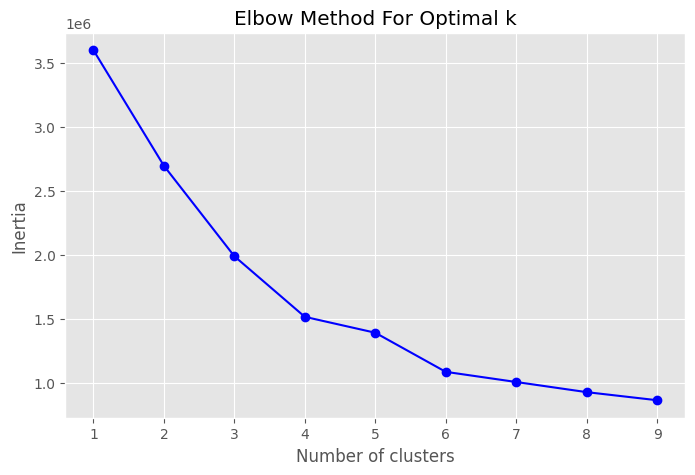

In [15]:
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features) 
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
features_all = all_df[['Annual Income', 'Insurance Duration', 'Vehicle Age']]
features_all = features_all.fillna(features_all.median())
features_all = (features_all - features_all.mean()) / features_all.std()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features)
all_df['Cluster'] = kmeans.predict(features_all)
train['Cluster'] = kmeans.predict(features)

cluster_median = train.groupby('Cluster')['Credit Score'].median()

def fill_credit_score(row):
    if pd.isnull(row['Credit Score']):
        return cluster_median[row['Cluster']]
    return row['Credit Score']

all_df['Credit Score'] = all_df.apply(fill_credit_score, axis=1)
all_df['Credit Score'].isnull().sum()

/tmp/ipykernel_26975/1719884411.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Cluster'] = kmeans.predict(features)


0

## Previous Claims

In [17]:
# all_df['Previous Claims'].value_counts(dropna=False)

Previous Claims
NaN    606831
0.0    508239
1.0    501692
2.0    279761
3.0     81764
4.0     17689
5.0      3411
6.0       506
7.0        86
8.0        12
9.0         9
Name: count, dtype: int64

In [18]:
# all_df['Previous Claims'].fillna(-1, inplace=True)
# all_df['Previous Claims'].isnull().sum()

0

# Train / Test

In [17]:
train = all_df[~all_df['Premium Amount'].isnull()]
test = all_df[all_df['Premium Amount'].isnull()]

train.shape, test.shape

((1200000, 36), (800000, 36))

# Preprocessing

In [18]:
features = train.columns.drop(['id', 'Premium Amount', 'log_Premium_Amount', 'Annual Income'])
features

Index(['Age', 'Gender', 'Marital Status', 'Number of Dependents',
       'Education Level', 'Occupation', 'Health Score', 'Location',
       'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score',
       'Insurance Duration', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type', 'transformed_Annual_Income',
       'Year', 'Day', 'Month', 'Month_name', 'Day_of_week', 'Week', 'Year_sin',
       'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Group',
       'Cluster'],
      dtype='object')

In [19]:
object_columns = train[features].select_dtypes(include='object').columns.to_list()
numerical_columns = train[features].select_dtypes(exclude='object').columns.to_list()

In [20]:
num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessors = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, numerical_columns),
        ('cat', cat_preprocessor, object_columns),
    ]
)

In [21]:
train_prep = preprocessors.fit_transform(train[features])
test_prep = preprocessors.transform(test)

# Model

In [22]:
y = train['log_Premium_Amount']

In [23]:
x_train, x_val, y_train, y_val = train_test_split(train_prep, y, test_size=0.1, random_state=2024)

## Hyperparmeter

In [26]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 10, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 12),  # -1 means no limit
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "device_type": "cpu",
        "seed" : 2024,
        'verbose':-1 # no warning msg
    }

    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

    callbacks=[
        lgb.log_evaluation(period=50)
    ]

    model = lgb.train(
        param,
        dtrain,
        num_boost_round=300,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=callbacks
    )

    y_val_pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred, 0))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-12-26 06:09:27,864] A new study created in memory with name: no-name-476918f9-0899-4d76-b892-298f19ab9376


[50]	train's rmse: 1.09554	valid's rmse: 1.09768
[100]	train's rmse: 1.09546	valid's rmse: 1.09761
[150]	train's rmse: 1.09539	valid's rmse: 1.09754
[200]	train's rmse: 1.09533	valid's rmse: 1.09748
[250]	train's rmse: 1.09527	valid's rmse: 1.09741


[I 2024-12-26 06:09:36,331] Trial 0 finished with value: 1.0973476480222877 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'learning_rate': 0.0001317328070839621, 'feature_fraction': 0.764908729385583, 'bagging_fraction': 0.8772277868521681, 'bagging_freq': 7, 'min_data_in_leaf': 23, 'max_depth': 1, 'lambda_l1': 0.023580875732527283, 'lambda_l2': 0.0003697272698502443, 'min_gain_to_split': 0.03719007564751142}. Best is trial 0 with value: 1.0973476480222877.


[300]	train's rmse: 1.0952	valid's rmse: 1.09735
[50]	train's rmse: 4.18229	valid's rmse: 4.18074
[100]	train's rmse: 3.76454	valid's rmse: 3.76311
[150]	train's rmse: 3.08275	valid's rmse: 3.08155
[200]	train's rmse: 2.70195	valid's rmse: 2.70098
[250]	train's rmse: 2.23644	valid's rmse: 2.23585
[300]	train's rmse: 2.13576	valid's rmse: 2.13534


[I 2024-12-26 06:11:57,159] Trial 1 finished with value: 2.135335854356004 and parameters: {'boosting_type': 'dart', 'num_leaves': 264, 'learning_rate': 0.014010186645502925, 'feature_fraction': 0.9108957034937926, 'bagging_fraction': 0.9084169802332301, 'bagging_freq': 9, 'min_data_in_leaf': 83, 'max_depth': 7, 'lambda_l1': 0.3690453538894026, 'lambda_l2': 0.00024474917265253414, 'min_gain_to_split': 0.04294933321357704}. Best is trial 0 with value: 1.0973476480222877.


[50]	train's rmse: 5.05704	valid's rmse: 5.05527
[100]	train's rmse: 5.39098	valid's rmse: 5.38917
[150]	train's rmse: 5.4766	valid's rmse: 5.47479
[200]	train's rmse: 5.52309	valid's rmse: 5.52127
[250]	train's rmse: 5.54961	valid's rmse: 5.5478
[300]	train's rmse: 5.54378	valid's rmse: 5.54196


[I 2024-12-26 06:14:31,822] Trial 2 finished with value: 5.541963286306543 and parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'learning_rate': 0.00011892948996526587, 'feature_fraction': 0.6121736566005131, 'bagging_fraction': 0.801351131038248, 'bagging_freq': 10, 'min_data_in_leaf': 29, 'max_depth': 0, 'lambda_l1': 0.034732635181145624, 'lambda_l2': 0.18167138642852504, 'min_gain_to_split': 0.04944373783104945}. Best is trial 0 with value: 1.0973476480222877.


[50]	train's rmse: 1.09499	valid's rmse: 1.09713
[100]	train's rmse: 1.0944	valid's rmse: 1.09653
[150]	train's rmse: 1.09374	valid's rmse: 1.09588
[200]	train's rmse: 1.09318	valid's rmse: 1.09531
[250]	train's rmse: 1.09262	valid's rmse: 1.09475
[300]	train's rmse: 1.09211	valid's rmse: 1.09423


[I 2024-12-26 06:14:43,999] Trial 3 finished with value: 1.0942270286773945 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.0003921886407784751, 'feature_fraction': 0.6786916937481217, 'bagging_fraction': 0.6296601088811172, 'bagging_freq': 8, 'min_data_in_leaf': 46, 'max_depth': 4, 'lambda_l1': 0.005216562272821002, 'lambda_l2': 1.3646601814367731, 'min_gain_to_split': 0.062393847640038635}. Best is trial 3 with value: 1.0942270286773945.


[50]	train's rmse: 4.98258	valid's rmse: 4.98083
[100]	train's rmse: 5.23571	valid's rmse: 5.23393
[150]	train's rmse: 5.21882	valid's rmse: 5.21704
[200]	train's rmse: 5.18803	valid's rmse: 5.18626
[250]	train's rmse: 5.10652	valid's rmse: 5.10477
[300]	train's rmse: 5.05612	valid's rmse: 5.05438


[I 2024-12-26 06:16:15,239] Trial 4 finished with value: 5.054377931971577 and parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'learning_rate': 0.0011765089663001564, 'feature_fraction': 0.9140076746377657, 'bagging_fraction': 0.7296061749324051, 'bagging_freq': 5, 'min_data_in_leaf': 70, 'max_depth': 7, 'lambda_l1': 0.3649976387234627, 'lambda_l2': 0.3294608335460105, 'min_gain_to_split': 0.09640898104158686}. Best is trial 3 with value: 1.0942270286773945.


[50]	train's rmse: 1.07757	valid's rmse: 1.07978
[100]	train's rmse: 1.06695	valid's rmse: 1.06928
[150]	train's rmse: 1.05918	valid's rmse: 1.06168
[200]	train's rmse: 1.05528	valid's rmse: 1.05799
[250]	train's rmse: 1.05256	valid's rmse: 1.0555
[300]	train's rmse: 1.05088	valid's rmse: 1.05406


[I 2024-12-26 06:16:35,782] Trial 5 finished with value: 1.0540579890387085 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'learning_rate': 0.010087099696438574, 'feature_fraction': 0.6686804447049395, 'bagging_fraction': 0.8149717905597085, 'bagging_freq': 5, 'min_data_in_leaf': 83, 'max_depth': -1, 'lambda_l1': 0.00030612194834231003, 'lambda_l2': 0.019499119826231842, 'min_gain_to_split': 0.006604894873589834}. Best is trial 5 with value: 1.0540579890387085.


[50]	train's rmse: 1.08699	valid's rmse: 1.08938
[100]	train's rmse: 1.0796	valid's rmse: 1.08223
[150]	train's rmse: 1.07359	valid's rmse: 1.07649
[200]	train's rmse: 1.06933	valid's rmse: 1.07249
[250]	train's rmse: 1.06556	valid's rmse: 1.069
[300]	train's rmse: 1.06234	valid's rmse: 1.06606


[I 2024-12-26 06:16:59,219] Trial 6 finished with value: 1.0660560398771102 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'learning_rate': 0.003542762044957388, 'feature_fraction': 0.7502414606106631, 'bagging_fraction': 0.6384824101186736, 'bagging_freq': 8, 'min_data_in_leaf': 24, 'max_depth': 9, 'lambda_l1': 1.0230909913144333, 'lambda_l2': 0.0006778319331191997, 'min_gain_to_split': 0.017873271545134045}. Best is trial 5 with value: 1.0540579890387085.


[50]	train's rmse: 1.09525	valid's rmse: 1.0974
[100]	train's rmse: 1.09488	valid's rmse: 1.09703
[150]	train's rmse: 1.09452	valid's rmse: 1.09668
[200]	train's rmse: 1.0942	valid's rmse: 1.09636
[250]	train's rmse: 1.09388	valid's rmse: 1.09604
[300]	train's rmse: 1.09355	valid's rmse: 1.09572


[I 2024-12-26 06:17:24,060] Trial 7 finished with value: 1.0957202860719992 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'learning_rate': 0.00013618176874089812, 'feature_fraction': 0.7669669360788682, 'bagging_fraction': 0.7769069133183681, 'bagging_freq': 7, 'min_data_in_leaf': 99, 'max_depth': 8, 'lambda_l1': 0.0068129489176368884, 'lambda_l2': 0.1325593090590989, 'min_gain_to_split': 0.0780470136436305}. Best is trial 5 with value: 1.0540579890387085.


[50]	train's rmse: 1.07	valid's rmse: 1.07235
[100]	train's rmse: 1.06417	valid's rmse: 1.0666
[150]	train's rmse: 1.0609	valid's rmse: 1.06327
[200]	train's rmse: 1.05937	valid's rmse: 1.06175
[250]	train's rmse: 1.05843	valid's rmse: 1.06079
[300]	train's rmse: 1.05762	valid's rmse: 1.05999


[I 2024-12-26 06:17:36,303] Trial 8 finished with value: 1.0599878175746673 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'learning_rate': 0.04996160307094688, 'feature_fraction': 0.7239311833685151, 'bagging_fraction': 0.798730558519515, 'bagging_freq': 5, 'min_data_in_leaf': 30, 'max_depth': 3, 'lambda_l1': 1.0745631889859524, 'lambda_l2': 0.9993386394991196, 'min_gain_to_split': 0.0773830244370015}. Best is trial 5 with value: 1.0540579890387085.


[50]	train's rmse: 5.05183	valid's rmse: 5.05006
[100]	train's rmse: 5.38	valid's rmse: 5.37819
[150]	train's rmse: 5.45818	valid's rmse: 5.45637
[200]	train's rmse: 5.49892	valid's rmse: 5.49711
[250]	train's rmse: 5.51728	valid's rmse: 5.51547
[300]	train's rmse: 5.50792	valid's rmse: 5.50611


[I 2024-12-26 06:19:48,208] Trial 9 finished with value: 5.5061137430732865 and parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'learning_rate': 0.00019248139785036871, 'feature_fraction': 0.6029088891880177, 'bagging_fraction': 0.9374270614829768, 'bagging_freq': 8, 'min_data_in_leaf': 12, 'max_depth': 0, 'lambda_l1': 0.12275016249899372, 'lambda_l2': 0.07881714579753214, 'min_gain_to_split': 0.03792188820522844}. Best is trial 5 with value: 1.0540579890387085.


In [27]:
study.best_params, study.best_value

({'boosting_type': 'gbdt',
  'num_leaves': 61,
  'learning_rate': 0.010087099696438574,
  'feature_fraction': 0.6686804447049395,
  'bagging_fraction': 0.8149717905597085,
  'bagging_freq': 5,
  'min_data_in_leaf': 83,
  'max_depth': -1,
  'lambda_l1': 0.00030612194834231003,
  'lambda_l2': 0.019499119826231842,
  'min_gain_to_split': 0.006604894873589834},
 1.0540579890387085)

In [36]:
plot_optimization_history(study)

In [37]:
plot_param_importances(study)

## Train

In [24]:
best_params = study.best_params

dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

callbacks = [
    lgb.early_stopping(200),
    lgb.log_evaluation(period=50)
]

model_lgb = lgb.train(
    best_params,
    dtrain,
    num_boost_round=1500,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

Training until validation scores don't improve for 200 rounds
[50]	train's rmse: 1.074	valid's rmse: 1.07629
[100]	train's rmse: 1.06311	valid's rmse: 1.06554
[150]	train's rmse: 1.05714	valid's rmse: 1.0597
[200]	train's rmse: 1.05285	valid's rmse: 1.05565
[250]	train's rmse: 1.05058	valid's rmse: 1.05365
[300]	train's rmse: 1.04907	valid's rmse: 1.05242
[350]	train's rmse: 1.04807	valid's rmse: 1.05169
[400]	train's rmse: 1.04734	valid's rmse: 1.05127
[450]	train's rmse: 1.04674	valid's rmse: 1.05102
[500]	train's rmse: 1.04629	valid's rmse: 1.05087
[550]	train's rmse: 1.0459	valid's rmse: 1.05077
[600]	train's rmse: 1.04552	valid's rmse: 1.05067
[650]	train's rmse: 1.04518	valid's rmse: 1.0506
[700]	train's rmse: 1.04489	valid's rmse: 1.05058
[750]	train's rmse: 1.04458	valid's rmse: 1.05053
[800]	train's rmse: 1.04432	valid's rmse: 1.05052
[850]	train's rmse: 1.04404	valid's rmse: 1.05049
[900]	train's rmse: 1.04379	valid's rmse: 1.05049
[950]	train's rmse: 1.04353	valid's rmse: 1.

# Evaluation

In [25]:
y_val_pred = model_lgb.predict(x_val, num_iteration=model_lgb.best_iteration)

rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
------------------------------
RMSE: 1.0504
MAE: 0.7474
R²: 0.0845


/tmp/ipykernel_26975/640111917.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")


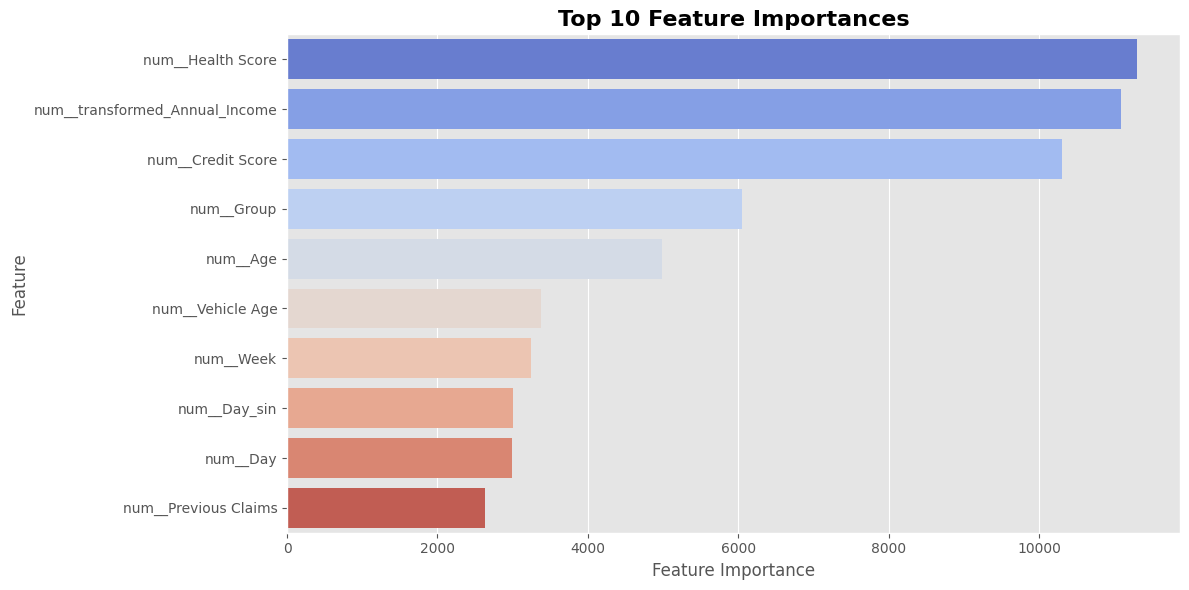

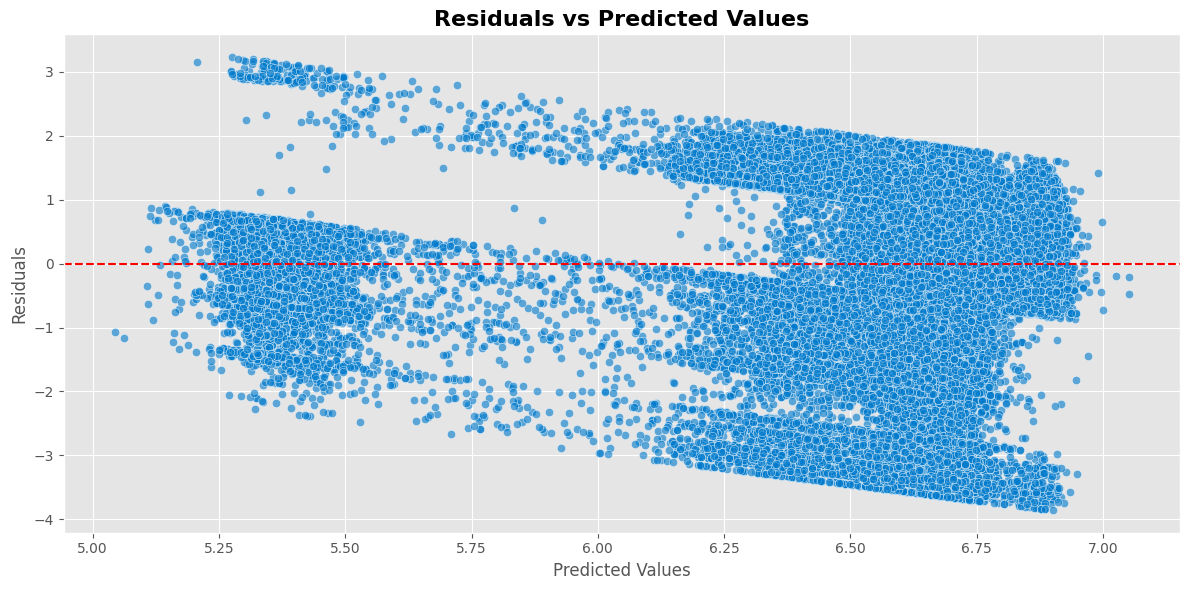

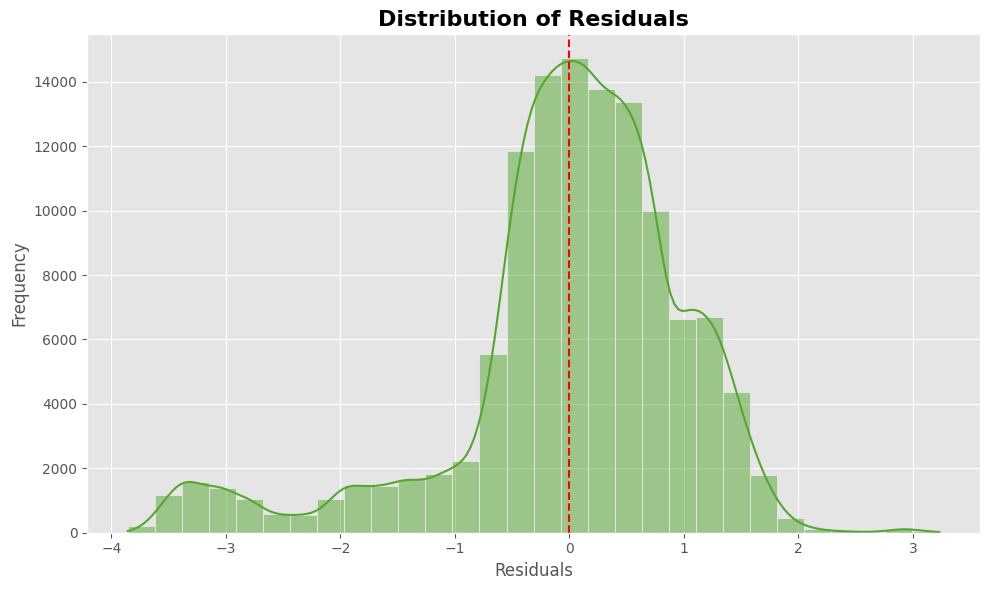

In [26]:
importances = model_lgb.feature_importance(importance_type='split')  # or 'gain'
features = preprocessors.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

residuals = y_val - y_val_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

In [ ]:
preds = model_lgb.predict(test_prep)
preds_exp = np.expm1(preds)
submission['Premium Amount'] = preds_exp
submission.head(20)

In [ ]:
submission.info()

In [ ]:
submission.to_csv('./data/03_1_submission.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/03_1_submission.csv" -m "03_1_submission"

> Public Score : 
- 1.06555 : with "Annual Income'
- 1.06559 : remove 'Annual Income'
- 1.06596 : metrc - rmsle
- 1.04506 : target - log, income - powertransform
    - 334 / 1693

> **Public Score Comparison**

- **Baseline Model:**
  - **Public Score:** 1.04849  
  - **Rank:** 498 / 1653  

- **Second Model (Feature Engineering + PowerTransformer):**
  - **Public Score:** 1.04506  
  - **Rank:** 334 / 1693  

---

> **Key Improvements**

1. **Date Features Added:**
   - Extracted date components (year, month, day) and applied **sin** and **cos** transformations to capture **cyclic patterns**.  

2. **Annual Income Preprocessing:**
   - Addressed **skewness** and **outliers** in the 'Annual Income' column using **PowerTransformer** for better normalization.  

3. **Target Value Transformation:**
   - Initially applied **PowerTransformer** to the target value, but it caused **Public Score deterioration** (RMSLE ~ 1.06).  
   - Switched to **log transformation** for the target, which better aligned with the **RMSLE evaluation metric**.  

---

> **Results Analysis**

- The **second model outperformed the baseline** in terms of **Public Score** and **ranking**, showing that  
  **feature engineering** and **data preprocessing** improved the model's ability to generalize.  
- Despite better **validation metrics**, the initial target transformation mismatch caused a drop in Public Score,  
  highlighting the importance of **consistency between preprocessing and evaluation metrics**.  
- Reverting to **log transformation** for the target resolved this issue and yielded a **better rank (334/1693)**.  
